In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 폐 영역분할

다음의 2019 대한의료인공지능학회 Summer School에서 진행한 AI hands-on의 자료에서 코드르 가져와서 수정함.

https://github.com/mi2rl/ai_handson/blob/master/KoSAIM_Summer_School_2019_Handson_03_Segmentation.ipynb


## 폐 데이터 다운로드

다음에서 다운받은 데이터

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [1]:
%%shell
rm -rf Lung_Segmentation.zip
wget https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/Lung_Segmentation.zip

--2020-11-03 06:14:15--  https://github.com/dhrim/hongik_2020/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/Lung_Segmentation.zip [following]
--2020-11-03 06:14:15--  https://raw.githubusercontent.com/dhrim/hongik_2020/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M   231MB/s    in 0.2s    

2020-11-03 06:14:15 (231 MB/s) -

In [2]:
%%shell
rm -rf Lung_Segmentation
unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

## 파일 보기

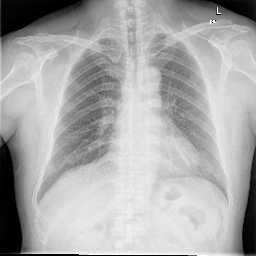

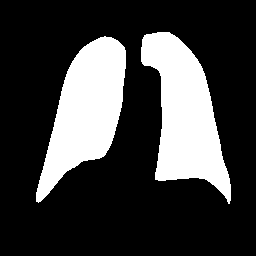

In [3]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))


## 데이터 로딩

In [4]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "./Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)

# file_headers = ['CHNCXR_0402_1', 'CHNCXR_0461_1', 'CHNCXR_0422_1', ... ]    
#print(file_headers)

raw_x = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
raw_y = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    # fh = "CHNCXR_0402_1"

    # f1 = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    # l1 = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]
    # img.shape = (256, 256, 3)

    mask = imread(l1)
    # mask.shape = (256, 256)

    mask = np.expand_dims(mask, axis=-1)
    # mask.shape = (256, 256, 1)

    raw_x[count] = img
    raw_y[count] = mask
    
    count += 1


## 원시 데이터 보기

In [5]:
print(raw_x[0])
print(raw_y[0])

[[[ 0  0  0]
  [64 64 64]
  [67 67 67]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [57 57 57]
  [55 55 55]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [55 55 55]
  [51 51 51]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


## 데이터 정규화

In [12]:
x_all = raw_x.astype('float32') / 255.
y_all = raw_y.astype('float32')

## 데이터 나누기

In [13]:
split_index = int(x_all.shape[0]*0.8)
train_x, test_x = x_all[:split_index], x_all[split_index:]
train_y, test_y = y_all[:split_index], y_all[split_index:]

In [14]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(452, 256, 256, 3)
(452, 256, 256, 1)
(114, 256, 256, 3)
(114, 256, 256, 1)


train


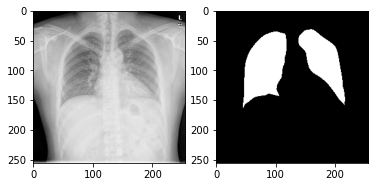

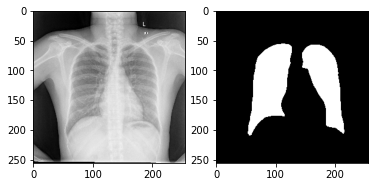

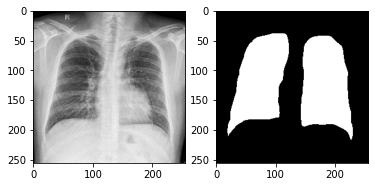

test


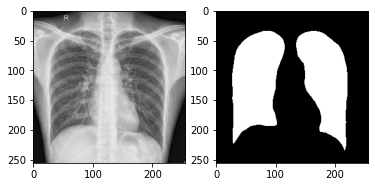

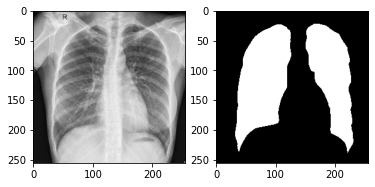

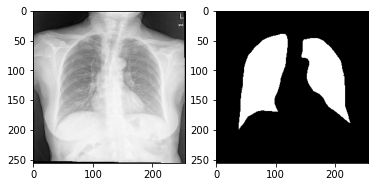

In [15]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## M-Net 모델 정의

In [16]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
# from tensorflow.keras import backend as keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# def unet(input_size=(256,256,3)):
#     inputs = Input(input_size)
    
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     conv1 = BatchNormalization()(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
#     conv5 = BatchNormalization()(conv5)
    
#     up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
#     conv6 = BatchNormalization()(conv6)
    
#     up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)
    
#     up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
#     conv8 = BatchNormalization()(conv8)
    
#     up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = BatchNormalization()(conv9)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
#     conv9 = BatchNormalization()(conv9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

#     return Model(inputs=[inputs], outputs=[conv10])

copy from https://github.com/adigasu/FDPMNet/blob/master/test.py

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from keras import backend as K

def getFPDMNet(patchHeight, patchWidth, ipCh, outCh):

    # Input
    input1 = Input((patchHeight, patchWidth, ipCh))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = concatenate([input1, conv1], axis=-1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #
    input2 = MaxPooling2D(pool_size=(2, 2))(input1)
    conv21 = concatenate([input2, pool1], axis=-1)

    conv2 = Conv2D(32, (3, 3), padding='same')(conv21)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)

    conv2 = concatenate([conv21, conv2], axis=-1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #
    input3 = MaxPooling2D(pool_size=(2, 2))(input2)
    conv31 = concatenate([input3, pool2], axis=-1)

    conv3 = Conv2D(64, (3, 3), padding='same')(conv31)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    
    conv3 = concatenate([conv31, conv3], axis=-1)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #
    input4 = MaxPooling2D(pool_size=(2, 2))(input3)
    conv41 = concatenate([input4, pool3], axis=-1)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv41)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)
    
    conv4 = concatenate([conv41, conv4], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # Decoder
    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv51 = concatenate([conv3, conv5], axis=-1)

    conv5 = Conv2D(64, (3, 3), padding='same')(conv51)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    conv5 = concatenate([conv51, conv5], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    #
    conv6 = UpSampling2D(size=(2, 2))(conv5)
    conv61 = concatenate([conv2, conv6], axis=-1)

    conv6 = Conv2D(32, (3, 3), padding='same')(conv61)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    conv6 = concatenate([conv61, conv6], axis=-1)
    conv6 = Conv2D(32, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    #
    conv7 = UpSampling2D(size=(2, 2))(conv6)
    conv71 = concatenate([conv1, conv7], axis=-1)

    conv7 = Conv2D(16, (3, 3), padding='same')(conv71)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    conv7 = concatenate([conv71, conv7], axis=-1)
    conv7 = Conv2D(16, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Final
    conv81 = UpSampling2D(size=(8, 8))(conv4)
    conv82 = UpSampling2D(size=(4, 4))(conv5)
    conv83 = UpSampling2D(size=(2, 2))(conv6)
    conv8 = concatenate([conv81, conv82, conv83, conv7], axis=-1)
    conv8 = Conv2D(outCh, (1, 1), activation='sigmoid')(conv8)

    ############
    model = Model(inputs=input1, outputs=conv8)

    # sgd = SGD(lr=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
    # model.compile(optimizer=sgd, loss=my_loss)

    return model

## 모델 컴파일과 학습

In [18]:
# 모델 생성
# model = unet()
model = getFPDMNet(patchHeight=256, patchWidth=256, ipCh=3, outCh=1)

# 모델 컴파일
# model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

lrate = 0.1
decay_Rate = 1e-6

def my_loss(y_true, y_pred):
    l1_loss = K.mean(K.abs(y_pred - y_true))
    return l1_loss
sgd = SGD(lr=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
model.compile(optimizer=sgd, loss=my_loss, metrics=['accuracy'])


# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)

# 모델 저장
model.save('mnet.h5')


Epoch 1/20
46/46 [==============================] - 9s 198ms/step - loss: 0.0926 - accuracy: 0.9203 - val_loss: 0.4029 - val_accuracy: 0.6331
Epoch 2/20
46/46 [==============================] - 8s 165ms/step - loss: 0.0464 - accuracy: 0.9577 - val_loss: 0.3675 - val_accuracy: 0.6519
Epoch 3/20
46/46 [==============================] - 8s 166ms/step - loss: 0.0366 - accuracy: 0.9665 - val_loss: 0.2525 - val_accuracy: 0.7567
Epoch 4/20
46/46 [==============================] - 8s 168ms/step - loss: 0.0325 - accuracy: 0.9699 - val_loss: 0.2081 - val_accuracy: 0.7963
Epoch 5/20
46/46 [==============================] - 8s 169ms/step - loss: 0.0297 - accuracy: 0.9723 - val_loss: 0.1901 - val_accuracy: 0.8135
Epoch 6/20
46/46 [==============================] - 8s 171ms/step - loss: 0.0284 - accuracy: 0.9733 - val_loss: 0.2163 - val_accuracy: 0.7794
Epoch 7/20
46/46 [==============================] - 8s 172ms/step - loss: 0.0281 - accuracy: 0.9734 - val_loss: 0.2921 - val_accuracy: 0.7116
Epoch 

## 학습시 로스와 정확도 보기

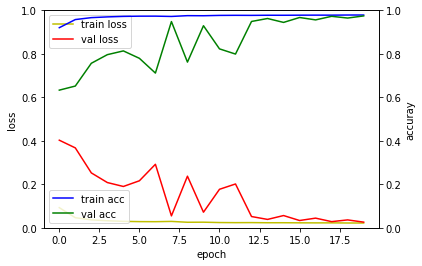

In [20]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [21]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 12ms/sample - loss: 0.0187 - acc: 0.9824


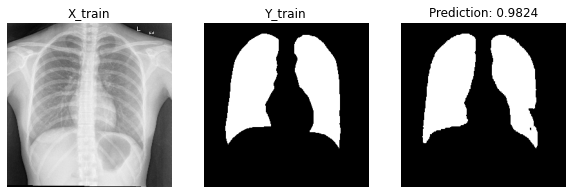

1/1 [==============================] - 0s 11ms/sample - loss: 0.1109 - acc: 0.8894


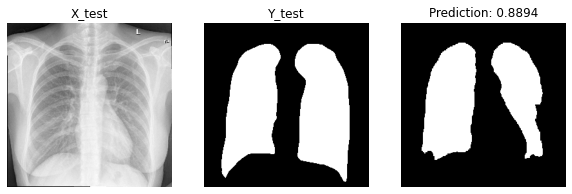

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)